# Partitioning

The system makes use of three different (train, predict) partitioning schemes, used at different points in the process. The three are currently given in the following form:

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

future_partitioner_dict = {"train":(121,492),"predict":(493,504)}

The numbers are month numbers, defined as number of months since December 1979. 444, then, is December 2015, and 504 December 2021. We change the periods for each of these partitions regularly, typically after an annual update of the most important input data is ready, and, in the case of the future partition, for each monthly update. For calibration and testing purposes, the 'predict' parts are 48 consecutive months.

The number of schemes is due to how VIEWS is training models in multiple stages -- using all data available while avoiding data leakage for the purposes of hyper-parameter tuning (short-hand for procedures for calibration, training model weights, and other hyper-parameter settings), testing of model performance, and future prediction.

The 'calib_partitioner' is used for hyper-parameter tuning for test purposes, the 'test_partitioner' for model training for test purposes as well as for hyper-parameter tuning for future predictions, and the 'future_partitioner' for model training for future predictions. In other words, when we do a run to test the performance of the model system, we do the following:

- train the constituent models on the 'train' part of the calib_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the test_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the test_partitioner, and evaluate these predictions against the actuals of this predict period.

For future predictions, we retrain all models to make use of all available data:

- train the constituent models on the 'train' part of the test_partitioner, predict on the 'predict' part of the same, train the hyper-parameters and ensemble weights on these predictions against the actuals in the 'predict' part of this partitioner
- retrain the constituent models with optimized hyper-parameters using the 'train' part of the future_partitioner, predict using the pre-trained ensemble weights for the 'predict' part of the future_partitioner. As true future predictions evaluation is not possible until at a later date.

In practice, the use of the partitioner is in fact a bit more involved than this, see the section on 'stepshifting' below.

In [1]:
# Use viewser env

from viewser import Queryset, Column
from ingester3.ViewsMonth import ViewsMonth

import urllib.request
import os
import pickle

import numpy as np
import pandas as pd

import random
import matplotlib.pyplot as plt

#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [2]:
from pkg_resources import get_distribution
installed_version = get_distribution('ingester3').version

if installed_version >= '1.8.1':
    print (f"You are running version {installed_version} which is consistent with the documentation")
else:
    print (f"""
You are running an obsolete version ({installed_version}). Run:
pip install ingester3 --upgrade 
to upgrade""")
    


You are running version 1.9.1 which is consistent with the documentation


In [4]:
!viewser tables show ged2_pgm


  > Ged2_pgm
  -------------------------------------------------------
  | name                    | path                    |
  |:------------------------|:------------------------|
  | priogrid_month_id       | priogrid_month_id       |
  | ged_sb_best_sum_nokgi   | ged_sb_best_sum_nokgi   |
  | ged_ns_best_sum_nokgi   | ged_ns_best_sum_nokgi   |
  | ged_os_best_sum_nokgi   | ged_os_best_sum_nokgi   |
  | ged_sb_best_count_nokgi | ged_sb_best_count_nokgi |
  | ged_ns_best_count_nokgi | ged_ns_best_count_nokgi |
  | ged_os_best_count_nokgi | ged_os_best_count_nokgi |
  | ged_sb_high_sum_nokgi   | ged_sb_high_sum_nokgi   |
  | ged_ns_high_sum_nokgi   | ged_ns_high_sum_nokgi   |
  | ged_os_high_sum_nokgi   | ged_os_high_sum_nokgi   |
  | ged_sb_high_count_nokgi | ged_sb_high_count_nokgi |
  | ged_ns_high_count_nokgi | ged_ns_high_count_nokgi |
  | ged_os_high_count_nokgi | ged_os_high_count_nokgi |
  | test                    | test                    |
  
  ---------------------------

In [5]:
def get_views_date():

    print('Beginning file download through viewser...')

    queryset_base = (Queryset("simon_tests", "priogrid_month")
        .with_column(Column("ln_sb_best", from_table = "ged2_pgm", from_column = "ged_sb_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
        .with_column(Column("ln_ns_best", from_table = "ged2_pgm", from_column = "ged_ns_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
        .with_column(Column("ln_os_best", from_table = "ged2_pgm", from_column = "ged_os_best_count_nokgi").transform.ops.ln().transform.missing.replace_na())
        .with_column(Column("month", from_table = "month", from_column = "month"))
        .with_column(Column("year_id", from_table = "country_year", from_column = "year_id"))
        .with_column(Column("c_id", from_table = "country_year", from_column = "country_id"))
        .with_column(Column("col", from_table = "priogrid", from_column = "col"))
        .with_column(Column("row", from_table = "priogrid", from_column = "row")))


    df = queryset_base.publish().fetch()

    df.reset_index(inplace = True)

    df.rename(columns={'priogrid_gid': 'pg_id'}, inplace= True)

    df['in_viewser'] = True

    month_first = df[df['year_id'] == 1990]['month_id'].min() # Jan 1990
    month_last =  ViewsMonth.now().id - 2 # minus 1 because the current month is not yet available,

    df = df[df['month_id'] <= month_last].copy()
    df.loc[:,'abs_row'] = df.loc[:,'row'] - df.loc[:,'row'].min() 
    df.loc[:,'abs_col'] = df.loc[:,'col'] - df.loc[:,'col'].min()
    df.loc[:,'abs_month'] = df.loc[:,'month_id'] - month_first  


    return df

In [6]:
def df_to_vol(df):

    month_first = df['month_id'].min() # Jan 1990
    month_last =  df['month_id'].max() # minus 1 because the current month is not yet available,

    month_range = month_last - month_first + 1
    space_range = 180

    features_num = 8 # should be inferred from the number of columns in the dataframe... 
    
    #df = df_full[df_full['month_id'] <= month_last].copy()
    #df.loc[:,'abs_row'] = df.loc[:,'row'] - df.loc[:,'row'].min() 
    #df.loc[:,'abs_col'] = df.loc[:,'col'] - df.loc[:,'col'].min()
    #df.loc[:,'abs_month'] = df.loc[:,'month_id'] - month_first 
    
    vol = np.zeros([space_range, space_range, month_range, features_num])
    
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 0] = df['pg_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 1] = df['col'] # this is not what I want, I want the xcoord but...
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 2] = df['row'] # this is not what I want, I want the ycoord but...
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 3] = df['month_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 4] = df['c_id']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 5] = df['ln_sb_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 6] = df['ln_ns_best']
    vol[df['abs_row'], df['abs_col'], df['abs_month'], 7] = df['ln_os_best']
    
    vol = np.flip(vol, axis = 0) # flip the rows, so north is up.
    
    return vol

In [7]:
processed_location = '/home/simon/Documents/scripts/conflictNet/data/processed' # local
raw_location = '/home/simon/Documents/scripts/conflictNet/data/raw' # local

path_viewser_data = raw_location + '/latest_viewser_data.pkl'
path_vol = processed_location +  '/latest_vol.npy'

# create the folders if they don't exist
if not os.path.exists(raw_location):
    os.makedirs(raw_location)

if not os.path.exists(processed_location):
    os.makedirs(processed_location)

# check if the VIEWSER files exist
if os.path.isfile(path_viewser_data) == True:

    print('File already downloaded')
    df = pd.read_pickle(path_viewser_data)
   
else:
    print('Downloading file...')
    df = get_views_date()
    
    # save pkl
    print(f'Saving file to {path_viewser_data}')
    df.to_pickle(path_viewser_data)

# check if the volume exists
if os.path.isfile(path_vol) == True:

    print('Volume already created')
    vol = np.load(path_vol)

else:
    print('Creating volume...')

    # create volume
    vol = df_to_vol(df)

    print(f'Saving volume to {path_vol}')
    # save npy
    np.save(path_vol, vol)


Beginning file download through viewser...
 .    Saving file to /home/simon/Documents/scripts/conflictNet/data/raw/latest_viewser_data.pkl
Creating volume...
Saving volume to /home/simon/Documents/scripts/conflictNet/data/processed/latest_vol.npy


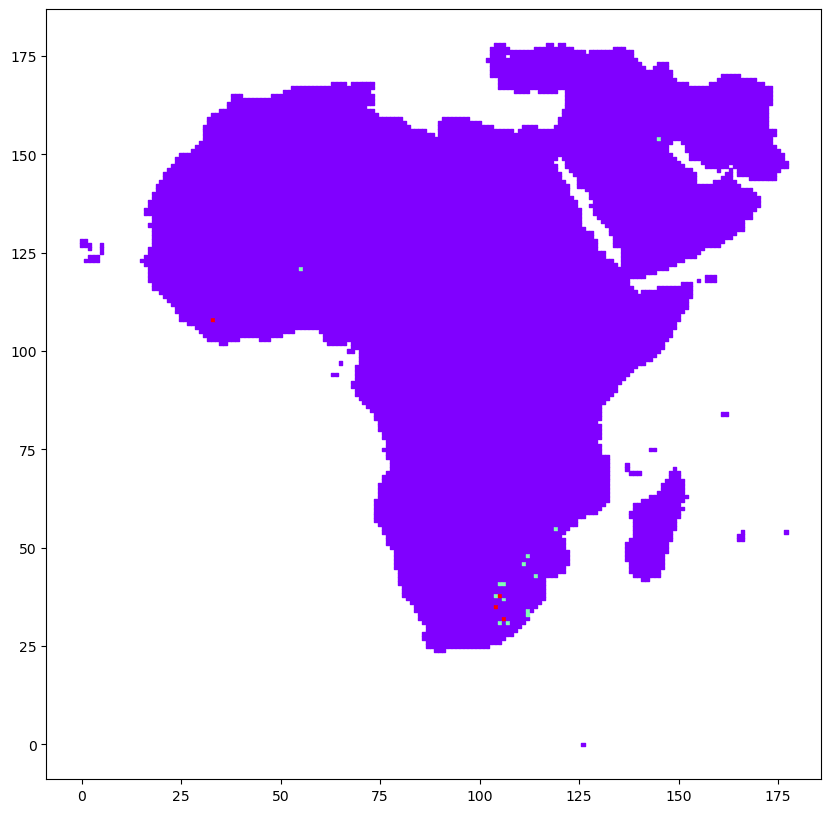

In [8]:
t0_df = df[df['abs_month'] == 1]

plt.figure(figsize = (10,10))
plt.scatter(t0_df['abs_col'], t0_df['abs_row'], c = t0_df['ln_os_best'], s = 6, marker='s', cmap = 'rainbow')
plt.show()

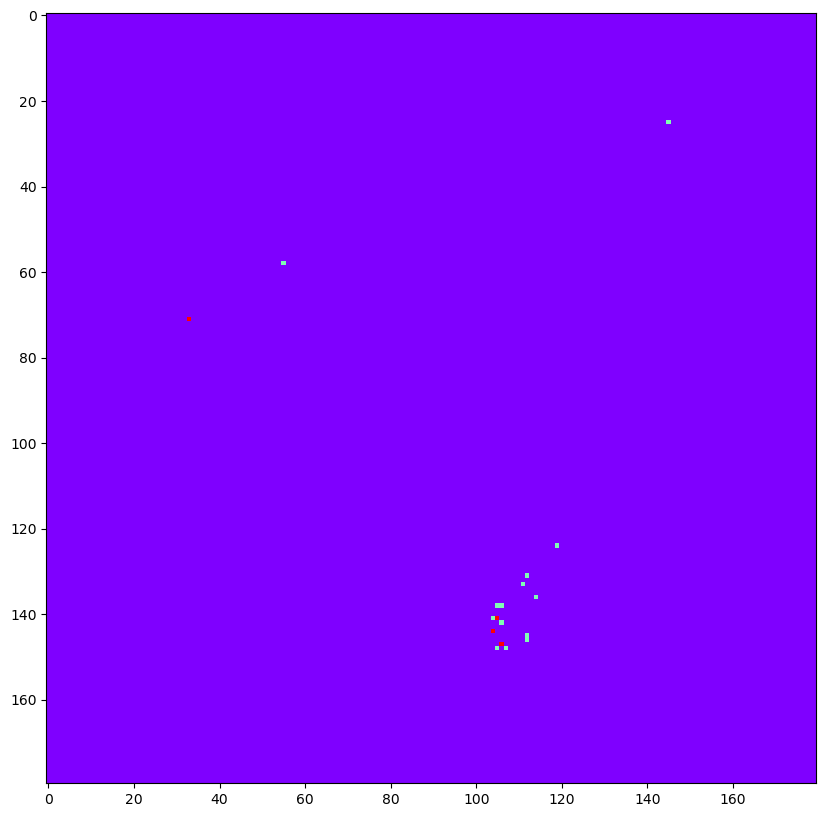

In [9]:
plt.figure(figsize = (10,10))

plt.imshow(vol[:,:,1,7], cmap='rainbow')
plt.show()

In [ ]:
# Get the number of rows and columns based on the maximum row and column indices
num_rows = np.max(df['col']) + 1 - np.min(df['col'])
num_cols = np.max(df['row']) + 1 - np.min(df['row'])



num_month = np.max(df['month_id']) + 1 - np.min(df['month_id'])

print(f"The array will have {num_rows} rows and {num_cols} columns")

# Initialize a sparse array filled with zeroes
#array = np.zeros((num_rows, num_cols, ))

#print(array.shape)

#array[df['abs_row'], df['abs_col']] = df['ln_sb_best']

# Fill the sparse array with values from the DataFrame
#sparse_array[row_index, col_index] = df[value_col]

In [ ]:
(array > 0).sum()

In [ ]:
plt.imshow(array, cmap='hot', interpolation='nearest')
plt.show()

In [ ]:




full_grid.fillna({'ln_sb_best' : 0, 'ln_ns_best' : 0, 'ln_os_best' : 0, 'c_id' : 0, 'in_viewser' : False}, inplace = True) # for c_id 0 is no country

#full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).transform(lambda x: x.fillna(x.mean(skipna = True)))['month_id'] # I think this is cool, but must check...
full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).apply(lambda x: x.fillna(x.mean(skipna = True)))['month_id']

# Drop stuff..
full_grid.dropna(inplace=True)

# the point of this is to drop months that were not give and month_id. The PRIO grid explosion makes only whole years, so this removes any excess months
return full_grid

In [ ]:
def get_prio_shape(location):

    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    prio_grid.rename(columns={'gid': 'pg_id'}, inplace= True)

    return prio_grid

In [ ]:
def monthly_grid(prio_grid, views_df):

    years = [sorted(views_df['year_id'].unique())] * prio_grid.shape[0]
    #months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    months = [sorted(views_df['month'].unique())] * prio_grid.shape[0] # then you only get one for the test runs# expensive to get these

    prio_grid['year_id'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year_id').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    prio_grid['year_id'] = prio_grid['year_id'].astype(int)
    prio_grid['month'] = prio_grid['month'].astype(int)

# --------------------

    # # Add month_id - Hack - but likely more robust... and prone to error:
    # prio_grid['year_month'] = prio_grid['year_id'].astype(str) + '_' + prio_grid['month'].astype(str) 

    # ts = prio_grid['year_month'].unique()
    # n_ts = len(ts)
    # month_ids = np.arange(109, n_ts + 109, 1)
    # month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    # prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    # prio_grid.drop(columns=['year_month'], inplace= True)

# ------------------------

    # # Add month_id - Hack, but it works:
    #prio_grid['year_month'] = prio_grid['year'].astype(str) + '_' + prio_grid['month'].astype(str)
    #month_ids = np.arange(views_df['month_id'].min(), views_df['month_id'].max()+1, 1)
    # month_ids = sorted(views_df['month_id'].unique())

    # ts = prio_grid['year_month'].unique()
    # month_id_df = pd.DataFrame({'year_month' : ts, 'month_id': month_ids})
    # prio_grid = prio_grid.merge(month_id_df, on = 'year_month', how = 'left')

    # Merge
    full_grid = prio_grid.merge(views_df, on = ['pg_id', 'year_id', 'month'], how = 'left')

    full_grid.fillna({'ln_sb_best' : 0, 'ln_ns_best' : 0, 'ln_os_best' : 0, 'c_id' : 0, 'in_viewser' : False}, inplace = True) # for c_id 0 is no country

    #full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).transform(lambda x: x.fillna(x.mean(skipna = True)))['month_id'] # I think this is cool, but must check...
    full_grid["month_id"] = full_grid.groupby(["year_id", "month"]).apply(lambda x: x.fillna(x.mean(skipna = True)))['month_id']


    # Drop stuff..
    full_grid.dropna(inplace=True)
    # the point of this is to drop months that were not give and month_id. The PRIO grid explosion makes only whole years, so this removes any excess months

    return full_grid

In [ ]:
def get_sub_grid(grid, views_df):

        views_gids = views_df['pg_id'].unique()

        # get both dim to 180. Fine since you maxpool(2,2) two time: 180 -> 90 -> 45
        # A better number might be 192 since: 192 -> 96 -> 48 -> 24 -> 12 -> 6 -> 3
        max_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].max() + (1,1) 
        min_coords = grid[grid['pg_id'].isin(views_gids)][['xcoord', 'ycoord']].min() - (1,0.25) 
        
        # Maks it
        mask1 = ((grid['xcoord'] < max_coords[0]) & (grid['xcoord'] > min_coords[0]) & (grid['ycoord'] < max_coords[1]) & (grid['ycoord'] > min_coords[1]))
        grid = grid[mask1].copy()

        return grid

In [ ]:
def make_volumn(grid):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = grid[['pg_id', 'xcoord', 'ycoord', 'month_id', 'c_id', 'ln_sb_best', 'ln_ns_best', 'ln_os_best']].copy() # remove the everything also the geo col. What about in_viewser?

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [ ]:
def compile():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/number_one/Documents/scripts/conflictNet/data/raw'

    calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}

    test_partitioner_dict = {"train":(121,444),"predict":(445,492)}

    future_partitioner_dict = {"train":(121,492),"predict":(493,504)}

    df = get_views_date(location, calib_partitioner_dict)
    print('done 1')
    grid = get_prio_shape(location)
    print('done 2')
    grid = monthly_grid(grid, df)
    print('done 3')
    grid = get_sub_grid(grid, df)
    print('done 4')
    
    return grid

# Make grid

In [ ]:
grid = compile()

In [ ]:
grid.isna().any()

In [ ]:
grid['month_id'].unique()

In [ ]:
print(len(grid['xcoord'].unique()))
print(len(grid['ycoord'].unique()))

In [ ]:
grid.head()

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_os_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_ns_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

In [ ]:
mask = (grid['month_id'] == 121) #& (grid['in_viewser'] == True)

x = grid.loc[mask, 'xcoord']
y = grid.loc[mask, 'ycoord']

s = grid.loc[mask,'ln_sb_best']

base = world.plot(color='white', edgecolor='black', figsize = [25,25])

base.scatter(x, y, s= 6, c = s, marker= '.', cmap = 'rainbow', alpha =0.8, vmin = 0, vmax = grid['ln_sb_best'].max())

title = f"{grid.loc[mask, 'month'].mean()}, {grid.loc[mask, 'year_id'].mean()}"
plt.title(title)

plt.show()

# Make volumn

In [ ]:
grid.shape

In [ ]:
grid.isna().any()

In [ ]:
grid[grid['month_id'].isna()]['month'].unique()

In [ ]:
grid[grid['month_id'].isna()]['year_id'].unique()

In [ ]:
vol = make_volumn(grid)

In [ ]:
vol.shape

In [ ]:
for i in range(3): #vol.shape[0]):

    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    month = vol[i,:,:,3].mean()

    true_sb_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,5])
    axs[0].imshow(true_sb_masked, cmap = 'rainbow')
    axs[0].set_title(f"sb, {month}")
    
    true_ns_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,6])
    axs[1].imshow(true_ns_masked, cmap = 'rainbow')
    axs[1].set_title(f"ns, {month}")
    
    true_os_masked = np.ma.masked_where((vol[0,:,:,4] == 0), vol[i,:,:,7])
    axs[2].imshow(true_os_masked, cmap = 'rainbow')
    axs[2].set_title(f"os, {month}")

    plt.show()

## From pickle

In [ ]:
location = '/home/number_one/Documents/scripts/conflictNet/data/raw/'
file = '/viewser_monthly_vol_calib_sbnsos.pkl'

with (open(f'{location + file}', 'rb')) as f:
    vol_t = pickle.load(f)


In [ ]:
for i in range(3): #vol.shape[0]):

    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    month = vol_t[i,:,:,3].mean()

    true_sb_masked = np.ma.masked_where((vol_t[0,:,:,4] == 0), vol_t[i,:,:,5])
    axs[0].imshow(true_sb_masked, cmap = 'rainbow')
    axs[0].set_title(f"sb, {month}")
    
    true_ns_masked = np.ma.masked_where((vol_t[0,:,:,4] == 0), vol_t[i,:,:,6])
    axs[1].imshow(true_ns_masked, cmap = 'rainbow')
    axs[1].set_title(f"ns, {month}")
    
    true_os_masked = np.ma.masked_where((vol_t[0,:,:,4] == 0), vol_t[i,:,:,7])
    axs[2].imshow(true_os_masked, cmap = 'rainbow')
    axs[2].set_title(f"os, {month}")

    plt.show()

# from computerome:

In [ ]:
location = '/home/number_one/Documents/scripts/conflictNet/data/raw/'
file = '/viewser_monthly_vol_furture_sbnsos.pkl'

with (open(f'{location + file}', 'rb')) as f:
    vol_t2 = pickle.load(f)

In [ ]:
for i in range(11): #vol.shape[0]):

    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    month = vol_t2[i,:,:,3].mean()

    true_sb_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,5])
    axs[0].imshow(true_sb_masked, cmap = 'rainbow')
    axs[0].set_title(f"sb, {month}")
    
    true_ns_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,6])
    axs[1].imshow(true_ns_masked, cmap = 'rainbow')
    axs[1].set_title(f"ns, {month}")
    
    true_os_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,7])
    axs[2].imshow(true_os_masked, cmap = 'rainbow')
    axs[2].set_title(f"os, {month}")

    plt.show()

In [ ]:
ucpd_vol_count_t2 = np.count_nonzero(vol_t2[:,:,:,5], axis = 0)

In [ ]:
ucpd_vol_count_t2.shape

In [ ]:
ucpd_vol_count_t2 = np.count_nonzero(vol_t2[:,:,:,5:8], axis = 0)

In [ ]:
ucpd_vol_count_t2.sum(axis=2).shape

In [ ]:
def draw_window(ucpd_vol, min_events, sample):

    """Draw/sample a window/patch from the traning tensor.
    The dimensions of the windows are HxWxD, 
    where H=D in {16,32,64} and D is the number of months in the training data.
    The windows are constrained to be sampled from an area with some
    minimum number of log_best events (min_events)."""

    # with coordinates in vol, log best was 7 #CHANGED FOR VIEWSER
#    ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,5], axis = 0) #CHANGED FOR VIEWSER
    ucpd_vol_count = np.count_nonzero(ucpd_vol[:,:,:,5:8], axis = 0).sum(axis=2) #for either sb, ns, os


    # number of events so >= 1 or > 0 is the same as np.nonzero
    min_events_index = np.where(ucpd_vol_count >= min_events) 

    min_events_row = min_events_index[0]
    min_events_col = min_events_index[1]

    # it is index... Not lat long.
    min_events_indx = [(row, col) for row, col in zip(min_events_row, min_events_col)] 
    
    indx = random.choice(min_events_indx)

    dim = np.random.choice([16, 32, 64]) 

    # if you wnat a random temporal window, it is here.
    window_dict = {'lat_indx':indx[0], 'long_indx':indx[1], 'dim' : dim} 

    return(window_dict)


In [ ]:
# def get_train_tensors(ucpd_vol, config, sample):
def get_train_tensors(ucpd_vol, sample):

      # train_ucpd_vol = ucpd_vol[:-config.time_steps] # not tha last 36 months - these ar for test set
    train_ucpd_vol = ucpd_vol[:-48] # not tha last 36 months - these ar for test set


    # The lenght of a whole time lime.
    seq_len = train_ucpd_vol.shape[0]

    # To handle "edge windows"
    while True:
        try:
            #window_dict = draw_window(ucpd_vol = ucpd_vol, min_events = config.min_events, sample= sample)
            window_dict = draw_window(vol_t2, 22, sample)

            min_lat_indx = int(window_dict['lat_indx'] - (window_dict['dim']/2)) 
            max_lat_indx = int(window_dict['lat_indx'] + (window_dict['dim']/2))
            min_long_indx = int(window_dict['long_indx'] - (window_dict['dim']/2))
            max_long_indx = int(window_dict['long_indx'] + (window_dict['dim']/2))

            #HBL = np.random.randint(7,10,1).item()#CHANGED FOR VIEWSER
            #HBL = 5:8 # right now just the log_best #CHANGED FOR VIEWSER

            #input_window = train_ucpd_vol[ : , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 5:8].reshape(1, seq_len, window_dict['dim'], window_dict['dim'], config.input_channels)
            input_window = train_ucpd_vol[ : , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 5:8].reshape(1, seq_len, window_dict['dim'], window_dict['dim'], 3)
            break

        except:
            print('Resample edge', end= '\r') # if you don't like this, simply pad to whol volume from 180x180 to 192x192. But there is a point to a avoide edges that might have wierd artifacts.
            continue

    # 0 since this is constant across years. 1 dim for batch and one dim for time.
    # gids = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 0].reshape(1, 1, window_dict['dim'], window_dict['dim'])
    # longitudes = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 1].reshape(1, 1, window_dict['dim'], window_dict['dim'])
    # latitudes = train_ucpd_vol[0 , min_lat_indx : max_lat_indx , min_long_indx : max_long_indx, 2].reshape(1, 1, window_dict['dim'], window_dict['dim']) 

    # gids_tensor = torch.tensor(gids, dtype=torch.int) # must be int. You don't use it any more.
    # longitudes_tensor = torch.tensor(longitudes, dtype=torch.float)
    # latitudes_tensor = torch.tensor(latitudes, dtype=torch.float)

    # meta_tensor_dict = {'gids' : gids_tensor, 'longitudes' : longitudes_tensor, 'latitudes' : latitudes_tensor }
    # train_tensor = torch.tensor(input_window).float()

    # return(train_tensor, meta_tensor_dict)

    return(input_window)

In [ ]:
input_window = get_train_tensors(vol_t2, 1)

In [ ]:
print(input_window.shape)
print(input_window.squeeze()[0,:,:,:].shape)

In [ ]:
    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    month = vol_t2[i,:,:,3].mean()

    true_sb_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,5])
    axs[0].imshow(true_sb_masked, cmap = 'rainbow')
    axs[0].set_title(f"sb, {month}")
    
    true_ns_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,6])
    axs[1].imshow(true_ns_masked, cmap = 'rainbow')
    axs[1].set_title(f"ns, {month}")
    
    true_os_masked = np.ma.masked_where((vol_t2[0,:,:,4] == 0), vol_t2[i,:,:,7])
    axs[2].imshow(true_os_masked, cmap = 'rainbow')
    axs[2].set_title(f"os, {month}")

In [ ]:
input_window[:,i,:,:].squeeze().shape

In [ ]:
for i in range(10): #input_window.shape(1):

    fig, axs  = plt.subplots(1,3, figsize= (15,15))

    axs[0].imshow(input_window.squeeze()[i,:,:,0])
    axs[1].imshow(input_window.squeeze()[i,:,:,1])
    axs[2].imshow(input_window.squeeze()[i,:,:,2])
    
    plt.show()

In [ ]:
w = draw_window(vol_t2, 10, 1)

In [ ]:
w